## Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Data

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.shape

(7591, 2)

In [3]:
batch_size = 16

datagen = ImageDataGenerator()
datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='raw',
    seed=12349)

features, target = next(datagen_flow)

Found 7591 validated image filenames.


## EDA

In [4]:
labels.describe(include='all')

,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,000456.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


<AxesSubplot:xlabel='real_age', ylabel='Count'>

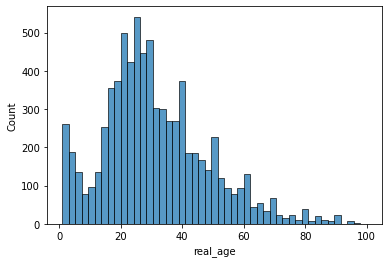

In [5]:
sns.histplot(labels['real_age'])

In [6]:
labels['real_age'].quantile(0.05)

5.0

In [7]:
labels['real_age'].quantile(0.95)

63.0

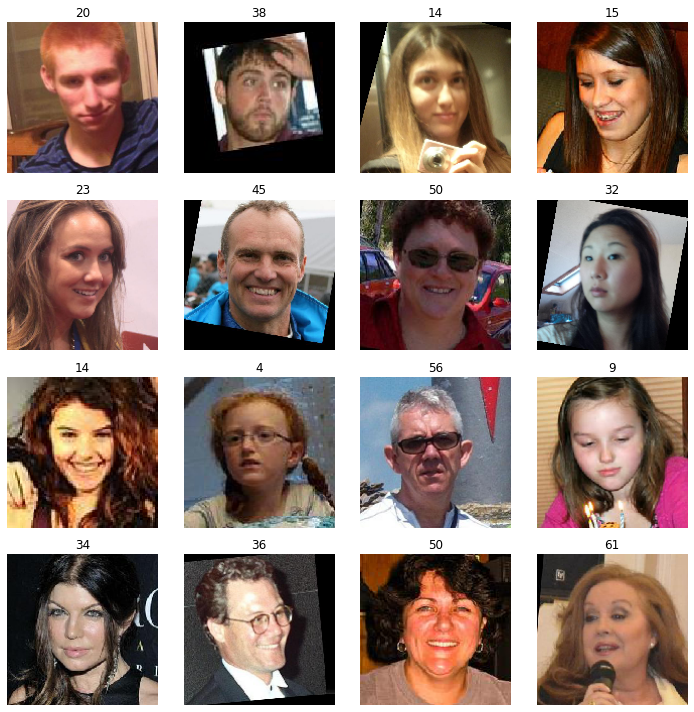

In [17]:
features, target = next(datagen_flow)
plt.figure(figsize=(10,10))
for image, target, i in zip(features, target, range(batch_size)):
    plt.subplot(4,4,i+1)
    plt.imshow(image.astype(np.uint8))
    plt.title(target)
    plt.axis("off")
plt.tight_layout()

### Findings

○ The age distribution is skewed to the left. 75% of the people in the dataset are under 41. 

○ There is more representation of baby faces then senior faces. 5% of the people in the data set are age 5-1, while another 5% are age 63-100. The range of seniors is larger by approximately 7 times, then the range of babies.

> There should be high quality model recognition for young faces (under 63) because there is mostly data of young people. This could harm the models prediction quality for senior faces. Because there is less representation of old people, the model will have trouble learning to distinguish between old faces.


For our purposes of creating a model that stops the selling of alcohol to minors, it does not have to have high quality predictions of seniors who are legally allowed to drink alcohol. We want high quality prediction for people around the age of 21-18 (legal age threshold for buying alcohol). Thus for our purposes the data set is good for model training to produce the desired results.

○ The images have been augmented by rotations, shrinking, and scale adjusment.

○ The pictures with older people seem to have more white pixels .

○ Some of the images are cropped in a way where the face are not visable to the naked eye.

> The model will imporove the prediction quality by learning augmented images. 

## Modelling

In [9]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [10]:
def load_train(path):
    
    labels = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(rescale = 1/255, validation_split=0.25)
    
    train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path+'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    subset='training',
    horizontal_flip=True,
    seed=12349)

    return train_gen_flow

In [11]:
def load_test(path):
    
    labels = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(rescale = 1/255, validation_split=0.25)
    
    test_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path+'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12349)


    return test_gen_flow

In [14]:
def create_model(input_shape):
    
    model = Sequential()
    model.add(ResNet50(input_shape=input_shape, weights='imagenet', include_top=False))
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=12, activation='linear'))
    
    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error', metrics=['mae'])

    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


### Prepare the Script to Run on the GPU Platform

### Output

Found 5694 validated image filenames. <br>
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps

Epoch 1/10 <br>
356/356 - 53s - loss: 291.2922 - mae: 12.4319 - val_loss: 474.9852 - val_mae: 16.6499

Epoch 2/10 <br>
356/356 - 35s - loss: 73.5306 - mae: 6.5961 - val_loss: 201.0387 - val_mae: 10.9256

Epoch 3/10 <br>
356/356 - 35s - loss: 37.3870 - mae: 4.7500 - val_loss: 82.2637 - val_mae: 6.9034

Epoch 4/10 <br>
356/356 - 35s - loss: 23.9620 - mae: 3.7888 - val_loss: 71.8576 - val_mae: 6.3841

Epoch 5/10 <br>
356/356 - 35s - loss: 16.9348 - mae: 3.1745 - val_loss: 75.6104 - val_mae: 6.6188

Epoch 6/10 <br>
356/356 - 35s - loss: 12.8506 - mae: 2.7179 - val_loss: 70.8952 - val_mae: 6.2527

Epoch 7/10 <br>
356/356 - 35s - loss: 9.8619 - mae: 2.4002 - val_loss: 74.7755 - val_mae: 6.6624

Epoch 8/10 <br>
356/356 - 35s - loss: 8.8732 - mae: 2.2671 - val_loss: 75.1121 - val_mae: 6.4836

Epoch 9/10 <br>
356/356 - 35s - loss: 8.7969 - mae: 2.2297 - val_loss: 73.1422 - val_mae: 6.4781

Epoch 10/10 <br>
356/356 - 35s - loss: 8.9576 - mae: 2.2471 - val_loss: 73.6686 - val_mae: 6.3640

119/119 - 9s - loss: 73.6686 - mae: 6.3640 <br>
Test MAE: 6.3640

## Conclusions

The model has predicted the age of a customer with mean absoulute error of 6.3 years. <br>
For our purposes of monitoring alcohol purchases and customers age, this is a very big margin of error (if the customer is 17 or 22 he model might predict these individuals age incorrectly and lead to wrong results) if this is to be avoided the model should be able to classify an individual as below or above the legal age for alcohol consumption.

Age of a customer can be used for improving marketing and layout of store products and services, in order to increase revenue and reputation.
The margin of error is less then a generation (10-20 years), for this reason the model can be used to predict the customers age for analysis of consumer behavior per age group. By using the cameras throughout the store, we can look for age group patterns like- most frequent visits per department, average total bill, age distribution of customer entourage, response to sale, etc.
